# Flow Matching 2D Unconditional Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/flow_matching_2d_unconditional.ipynb)

This notebook demonstrates how to train and sample from a flow-matching model on a 2D toy dataset using JAX and Flax. We will cover data generation, model definition, training, sampling, and likelihood estimation.

## 1. Environment Setup

In this section, we set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage.

In [1]:
# Load autoreload extension for development convenience
%load_ext autoreload
%autoreload 2

In [2]:
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

In [3]:
if colab: # you may have to restart the runtime after installing the packages
    %pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples

In [4]:
# Set training and model restoration flags
overwrite_model = False
restore_model = True  # Use pretrained model if available
train_model = False  # Set to True to train from scratch

### Library Imports and JAX Backend Selection

In [5]:
# Import libraries and set JAX backend
import os
os.environ['JAX_PLATFORMS']="cuda" # select cpu instead if no gpu is available
# os.environ['JAX_PLATFORMS']="cpu"

from flax import nnx
import jax
import jax.numpy as jnp
import optax
from optax.contrib import reduce_on_plateau
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
# Specify the checkpoint directory for saving/restoring models
import orbax.checkpoint as ocp
checkpoint_dir = f"{os.getcwd()}/checkpoints/flow_matching_2d_example"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

## 2. Data Generation

We generate a synthetic 2D dataset using JAX. This section defines the data generation functions and visualizes the data distribution.

In [7]:
# Define a function to generate 2D box data using JAX
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import grain

@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45

    return data

In [8]:
# # Infinite data generator for training batches
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_boxes_jax(key, batch_size)

#     return x

data = make_boxes_jax(jax.random.PRNGKey(0), 500_000)

train_dataset_grain = (
    grain.MapDataset.source(np.array(data))
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
)

performance_config = grain.experimental.pick_performance_config(
            ds=train_dataset_grain,
            ram_budget_mb=1024 * 4,
            max_workers=None,
            max_buffer_size=None,
        )

dataset_batched = train_dataset_grain.batch(512).mp_prefetch(
            performance_config.multiprocessing_options
        )

train_iter = iter(dataset_batched)

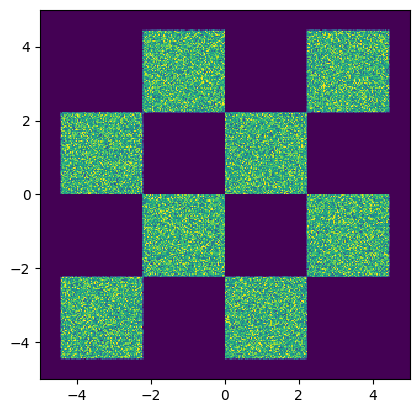

In [9]:
# Visualize the generated data distribution
samples = np.array(data)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

## 3. Model and Loss Definition

We define the velocity field model (an MLP), the loss function, and the optimizer for training the flow-matching model.

In [10]:
# Import flow matching components and utilities
from gensbi.flow_matching.path.scheduler import CondOTScheduler
from gensbi.flow_matching.path import AffineProbPath
from gensbi.flow_matching.solver import ODESolver
from gensbi.utils.model_wrapping import ModelWrapper
from gensbi.flow_matching.loss import ContinuousFMLoss

/home/zaldivar/miniforge3/envs/gensbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Define the MLP velocity field model
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, x: jax.Array, t: jax.Array, args=None):
        x = jnp.atleast_2d(x)
        t = jnp.atleast_1d(t)
        if len(t.shape)<2:
            t = t[..., None]
            t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))

        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x

In [12]:
# Initialize the velocity field model
hidden_dim = 512

# velocity field model init
vf_model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

In [13]:
# @markdown Define optimizer and learning rate schedule parameters
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
PATIENCE = 10  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Relative tolerance for measuring the new optimum:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100
RTOL = 1e-4  # @param{type:"number"}
# @markdown learnign rate
MAX_LR = 1e-3  # @param{type:"number"}
MIN_LR = 0  # @param{type:"number"}
MIN_SCALE = MIN_LR / MAX_LR

In [14]:
# Set up optimizer with reduce-on-plateau schedule
nsteps = 50_000

opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    # optax.adamw(warmup_schedule),
    optax.adamw(MAX_LR),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)

optimizer = nnx.Optimizer(vf_model, opt, wrt=nnx.Param)

In [15]:
# Restore the model from checkpoint if requested
if restore_model:
    checkpointer = ocp.StandardCheckpointer()
    state = nnx.state(vf_model)


    state = checkpointer.restore(checkpoint_dir + '/v1', target=state)
    # update the model with the loaded state
    nnx.update(vf_model, state)
    checkpointer.close()
    print("Model restored from checkpoint.")

Model restored from checkpoint.


## 4. Training Loop

This section defines the training and validation steps, and runs the training loop if enabled. Early stopping and learning rate scheduling are used for efficient training.

In [16]:
from numpyro import distributions as dist

# define the prior distribution, in this case a 2D gaussian with zero mean and unit variance, 
# but it could be any desired distribution, as long as it is compatible with the data dimension
p0 = dist.Independent(dist.Normal(jnp.zeros(2), jnp.ones(2)), 1)

# for example, we could also define a p0 as a 2D gaussian mixture, in case it made more sense as a prior
# in general though, a gaussian distribution is a good choice as a prior for flow matching

# p0 = dist.MixtureGeneral(
#     mixing_distribution=dist.Categorical(probs=jnp.array([0.5,0.5])),
#     component_distributions=[dist.Independent(
#         dist.Normal(
#             loc=jnp.array([-2.0, -2.0]),
#             scale=jnp.array([0.5, 0.5])
#         ), 1
#     ),
#     dist.Independent(
#         dist.Normal(
#             loc=jnp.array([2.0, 2.0]),
#             scale=jnp.array([0.5, 0.5])
#         ), 1
#     )]
# )

In [17]:
# Instantiate the affine path and loss function
path = AffineProbPath(scheduler=CondOTScheduler())

loss_fn = ContinuousFMLoss(path)

@nnx.jit
def train_step(vf_model, optimizer, batch):
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(vf_model, batch)
    optimizer.update(vf_model, grads, value=loss)  # In-place updates.

    return loss

In [18]:
# Generate validation data
val_data = make_boxes_jax(jax.random.PRNGKey(1), 512)

In [19]:
# Validation loss computation
@nnx.jit
def val_loss(model, key):
    subkey2, subkey3 = jax.random.split(key, 2)
    x_1 = val_data
    x_0 = p0.sample(subkey2, (x_1.shape[0],))
    t = jax.random.uniform(subkey3, x_1.shape[0])

    batch = (x_0, x_1, t)
    return loss_fn(model, batch)

In [20]:
# Import tqdm for progress bars and set early stopping flag
from tqdm import tqdm
early_stopping = True

In [21]:
# Initialize training state and tracking variables
best_state = nnx.state(vf_model)
best_val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100

loss_array = []
val_loss_array = []

rngs = nnx.Rngs(42)

The core part of a train step looks like this: 

```python
...
# Generate a batch of target data x_1 from the data generator
x_1 = next(train_iter)
# Sample x_0 from the standard normal prior, matching the shape of x_1
x_0 = p0.sample(rngs.train_step(), (x_1.shape[0],))
# Sample t uniformly in [0, 1] for each data point in the batch
t = jax.random.uniform(rngs.train_step(), x_1.shape[0])

# Prepare the batch tuple for the loss function
batch = (x_0, x_1, t)

train_step(vf_model, optimizer, batch)  # run the training step
...
```

We will now implement this in a context of a full training loop, with validation and early stopping.

In [22]:
# Main training loop (runs only if train_model=True)

# for each epoch, updated the model and then validate
# if the loss function stops improving, stop the training and restore the best model found so far

if train_model:
    vf_model.train()


    pbar = tqdm(range(nsteps))
    l = 0
    v_l = 0
    for j in pbar:
        if counter > cmax and early_stopping:
            print("Early stopping")
            # restore the model state to the best found so far
            graphdef, abstract_state = nnx.split(vf_model)

            vf_model = nnx.merge(graphdef, best_state)
            break

        # Generate a batch of target data x_1 from the data generator
        x_1 = next(train_iter)
        # Sample x_0 from the standard normal prior, matching the shape of x_1
        x_0 = p0.sample(rngs.train_step(), (x_1.shape[0],))
        # Sample t uniformly in [0, 1] for each data point in the batch
        t = jax.random.uniform(rngs.train_step(), x_1.shape[0])

        # Prepare the batch tuple for the loss function
        batch = (x_0, x_1, t)
        # Compute loss and update model parameters in-place
        loss = train_step(vf_model, optimizer, batch)  # update model parameters
        l += loss.item()

        # Compute validation loss for early stopping and LR scheduling
        v_loss = val_loss(vf_model, rngs.val_step())
        v_l += v_loss.item()

        if j > 0 and j % 100 == 0:
            # Compute average training and validation loss over the last 100 steps
            loss_ = l / 100
            val_ = v_l / 100

            # Compute ratios for early stopping and best model tracking
            ratio1 = val_ / loss_
            ratio2 = val_ / best_val_loss_value

            # If validation loss is not diverging, update best state if needed
            if ratio1 < val_error_ratio:
                if val_ < best_val_loss_value:
                    best_val_loss_value = val_
                    best_state = nnx.state(vf_model)
                elif ratio2 < 1.05:
                    best_state = nnx.state(vf_model) # still update the best state if the ratio is below 1.05

                counter = 0
            else:
                # If validation loss is diverging, increment early stopping counter
                counter += 1

            # Update progress bar with current metrics
            pbar.set_postfix(
                loss=f"{loss_:.4f}",
                ratio=f"{ratio1:.4f}",
                counter=counter,
                val_loss=f"{val_:.4f}",
            )
            loss_array.append(loss_)
            val_loss_array.append(val_)
            l = 0
            v_l = 0

    vf_model.eval()



In [23]:
# Save the trained model to checkpoint (if training was performed)
if train_model:
    checkpointer = ocp.StandardCheckpointer()
    model_state = nnx.state(vf_model)
    checkpointer.save(checkpoint_dir + '/v1.1', model_state)
    checkpointer.close()


## 5. Sampling from the Model

In this section, we sample trajectories from the trained flow-matching model and visualize the results at different time steps.

### sample the model

In [24]:
# Set model to evaluation mode before sampling
vf_model.eval()

# we need to wrap the model to accept x with ndim=3, ad produce an output of ndim=3,
# as that's the assumed input shape by the ODESolver
def vf_model_(obs,t, *args,**kwargs):
    obs = jnp.atleast_2d(obs)
    t = jnp.atleast_1d(t)
    if obs.ndim == 3:
        obs = jnp.squeeze(obs, axis=-1)
    if t.ndim == 3:
        t = jnp.squeeze(t, axis=-1)
    return vf_model(obs, t)[...,None]

In [25]:
# Wrap the model for ODE solver compatibility
vf_wrapped = ModelWrapper(vf_model_)

In [26]:
# Sample trajectories from the model using ODE solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 500_000  # batch size
T = jnp.linspace(0,1,10)  # sample times

x_init = p0.sample(jax.random.PRNGKey(0), (batch_size, ))  # initial conditions
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='Dopri5', step_size=step_size, return_intermediates=True)

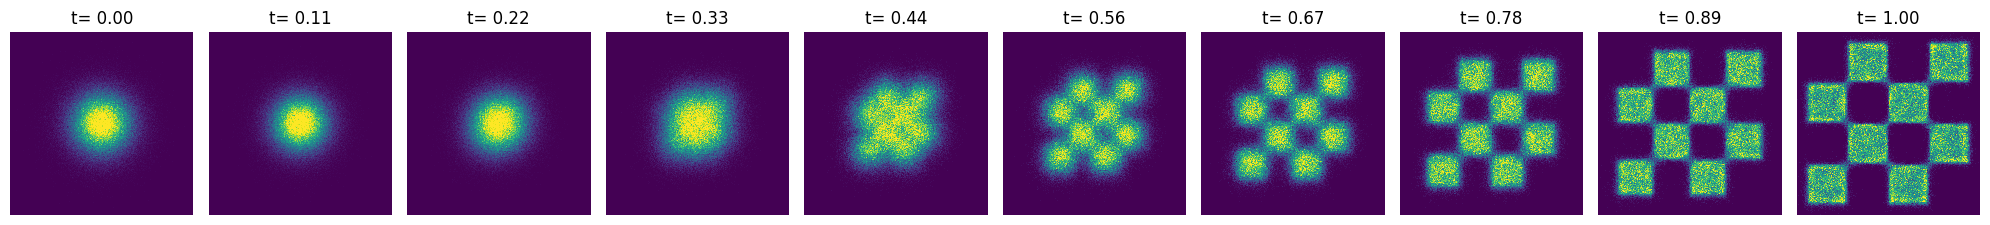

In [27]:
# Visualize the sampled trajectories at different time steps
sol = np.array(sol)  # convert to numpy array
T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))

    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
plt.show()

## 6. Marginal and Trajectory Visualization

We visualize the marginal distributions and sample trajectories from the model.

In [28]:
# Import plotting utility for marginals
from gensbi.utils.plotting import plot_marginals

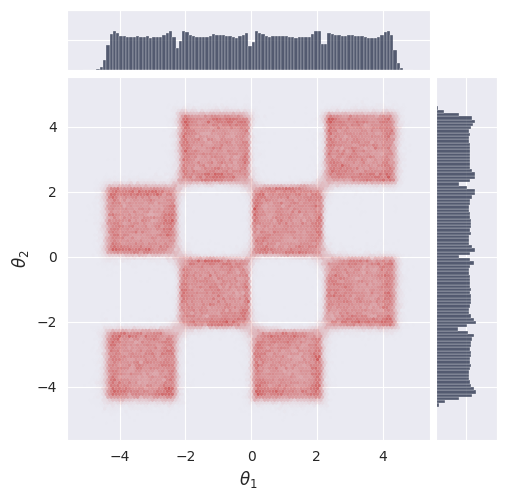

In [29]:
# Plot the marginal distribution of the final samples
plot_marginals(sol[-1], plot_levels=False, gridsize=100, backend="seaborn")
plt.show()

In [30]:
# Sample and visualize trajectories with finer time resolution
batch_size = 1000
T = jnp.linspace(0,1,50)  # sample times

x_init = p0.sample(jax.random.PRNGKey(0), (batch_size, ))  # initial conditions
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='Dopri5', step_size=step_size, return_intermediates=True)

In [31]:
# Import plotting utility for trajectories
from gensbi.utils.plotting import plot_trajectories

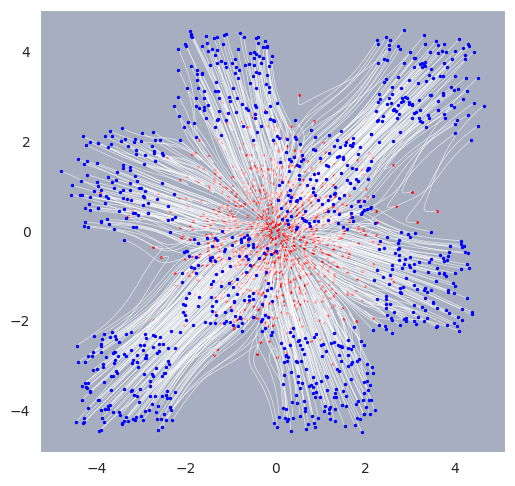

In [32]:
# Plot sampled trajectories
fig, ax = plot_trajectories(sol)
plt.grid(False)
plt.show()

## 7. Likelihood Estimation

This section demonstrates how to estimate and visualize the likelihood of the model on a grid of points in 2D space.

### sample the likelihood

In [33]:
# Import numpyro distributions for likelihood computation
import numpyro.distributions as dist

In [34]:
# Prepare grid for likelihood evaluation
T = jnp.array([1., 0.])  # sample times
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-5, 5, grid_size), jnp.linspace(-5, 5, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

In [35]:
# log_prob of the prior distribution
# Note: p0 is defined as an isotropic Gaussian with zero mean and unit variance
gaussian_log_density = p0.log_prob

In [36]:
# Compute unnormalized log-likelihood using the ODE solver
sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0], method='Dopri5', step_size=step_size, log_p0=gaussian_log_density)

exact_log_p = sampler(x_1)

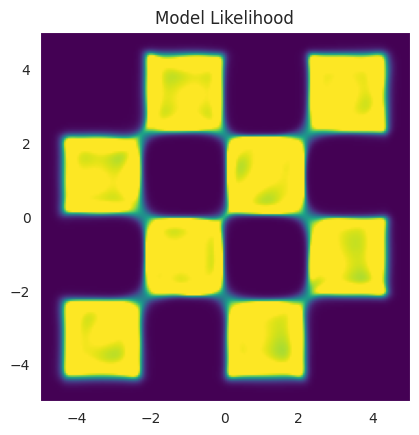

In [37]:
# Visualize the model likelihood on the 2D grid
likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

cmin = 0
cmax = 1/40.5 # the domain goes from -4.5 to 4.5. The total area is (4.5*2)**2. Since only half of the area is covered by the data likelihood, we divide by 2 -> (4.5*2)**2 / 2 = 40.5. As Such 1/40.5 is the max theoretical likelihood value
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

# Create the figure and axis objects explicitly
fig, ax = plt.subplots()

likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

im = ax.imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
ax.set_title('Model Likelihood')

plt.grid(False)
plt.show()